In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#data = pd.read_csv('logs/bo_runs_data_pressureswing_Vext_densB.csv')
#doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vext_densB.csv')

#data = pd.read_csv('logs/bo_runs_data_pressureswing_Vext_addfeatchempT.csv')
#doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vext_addfeatchempT.csv')

data = pd.read_csv('logs/bo_runs_data_pressureswing_Vext_addfeatchempT_densB.csv')
doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vext_addfeatchempT_densB.csv')

#data = pd.read_csv('logs/bo_runs_data_pressureswing_Vextchem_addfeatpT_densB.csv')
#doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vextchem_addfeatpT_densB.csv')

#data = pd.read_csv('logs/bo_runs_data_pressureswing_Vextchem_densB.csv')
#doto = pd.read_csv('logs/gp_summary_data_pressureswing_Vextchem_densB.csv')

/var/folders/p_/gl5tyfs92yg7lps1mzt8whdc0000gn/T/ipykernel_49302/2785007215.py:97: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  sc1 = ax.scatter(


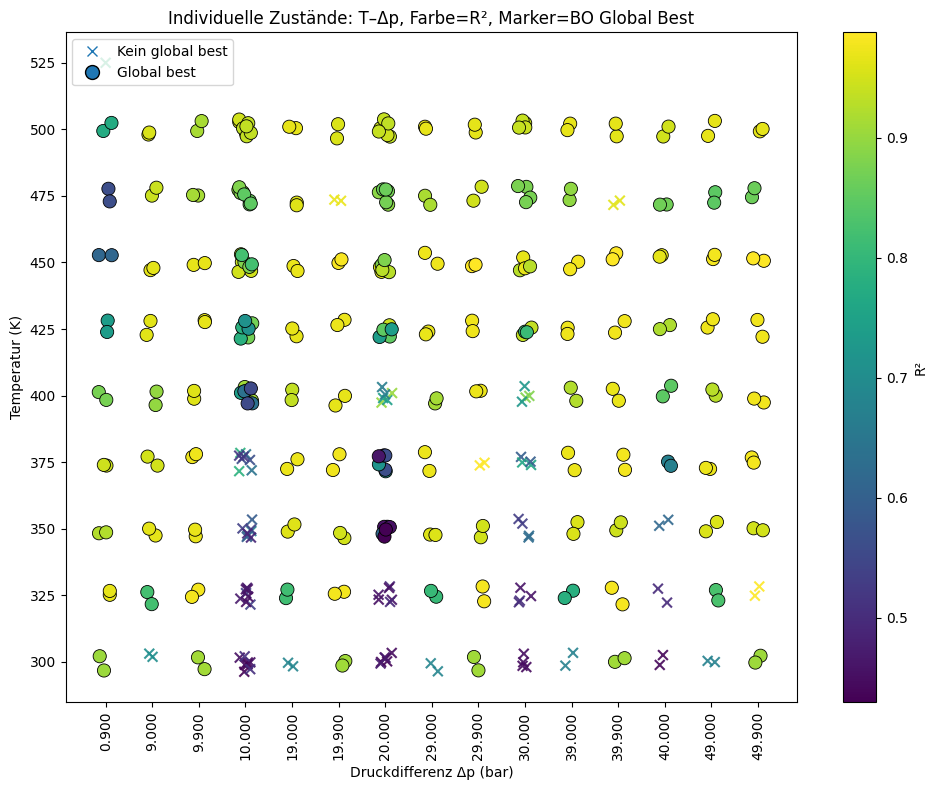

In [12]:
ROUND_TEMP = 0    # K
ROUND_P    = 3    # bar
ROUND_DP   = 3    # bar

# Wie stark Duplikate visuell versetzt werden (wenn exakt gleiche Koordinaten mehrfach vorkommen)
JITTER_DUP = 0.15     # Zellenbreiten-Einheiten im Scatter (0..0.3 sinnvoll)
RANDOM_SEED = 7       # None => jedes Mal anders

if RANDOM_SEED is not None:
    np.random.seed(RANDOM_SEED)

# Δp (absolut)
doto["delta_p"] = (doto["pressure_bar_2"] - doto["pressure_bar_1"]).abs()
data["delta_p"] = (data["pressure_bar_2"] - data["pressure_bar_1"]).abs()

# Bins/Keys für Merge – wähle *eine* der beiden Varianten unten (Var A empfohlen)
# -------------------------
# Variante A: auf (T, Δp) mergen
doto["T_key"] = doto["temperature_kelvin_1"].round(ROUND_TEMP)
doto["dp_key"] = doto["delta_p"].round(ROUND_DP)

data["T_key"] = data["temperature_kelvin_T1"].round(ROUND_TEMP)
data["dp_key"] = data["delta_p"].round(ROUND_DP)

merge_keys = ["T_key", "dp_key"]

# -------------------------
# Variante B: auf (T, p1, p2) mergen (falls Δp nicht eindeutig ist)
# doto["T_key"] = doto["temperature_kelvin_1"].round(ROUND_TEMP)
# doto["p1_key"] = doto["pressure_bar_1"].round(ROUND_P)
# doto["p2_key"] = doto["pressure_bar_2"].round(ROUND_P)
#
# data["T_key"] = data["temperature_kelvin_T1"].round(ROUND_TEMP)
# data["p1_key"] = data["pressure_bar_1"].round(ROUND_P)
# data["p2_key"] = data["pressure_bar_2"].round(ROUND_P)
#
# merge_keys = ["T_key", "p1_key", "p2_key"]

# =========================
# Individuelle Zustände zusammenführen (ohne Aggregation)
# =========================
# Wir behalten alle doto-Einträge (R²) und hängen die BO-Info dazu, falls vorhanden.
left_cols = [
    "temperature_kelvin_1", "pressure_bar_1", "pressure_bar_2",
    "delta_p", "r2", "T_key"
] + ([k for k in merge_keys if k not in ["T_key"]])

right_cols = ["found_global_best"] + merge_keys

states = doto[left_cols].merge(
    data[right_cols].drop_duplicates(subset=merge_keys),
    on=merge_keys, how="left"
)

# BO-Spalte säubern → bool
states["found_global_best"] = states["found_global_best"].fillna(False).astype(bool)

# =========================
# (Optional) Duplikat-Handling: exakt gleiche (T_key, dp_key) finden und Jitter-Offsets erzeugen
# =========================
# Index innerhalb gleicher Koordinaten bestimmen (0..n-1)
states["_dup_rank"] = states.groupby(merge_keys).cumcount()
# Wieviele pro Koordinate?
dup_counts = states.groupby(merge_keys)["_dup_rank"].transform("max") + 1

# Jitter nur, wenn mehr als 1 Punkt auf exakt gleicher Koordinate
# Wir erzeugen reproduzierbare kleine Offsets pro Punkt:
offset = (np.random.rand(len(states), 2) - 0.5) * 2 * JITTER_DUP
states["_jx"] = np.where(dup_counts > 1, offset[:,0], 0.0)
states["_jy"] = np.where(dup_counts > 1, offset[:,1], 0.0)

# =========================
# Scatter-Plot: jeder Punkt = ein individueller Zustand
# X = Δp, Y = Temperatur, Farbe = R², Marker = BO global best
# =========================
fig, ax = plt.subplots(figsize=(10, 8))

# Achsen-Skalen aus Daten (sortiert für tick-labels)
x_vals = np.sort(states["dp_key"].unique())
y_vals = np.sort(states["T_key"].unique())

# Mapping von Key -> Position auf Achse
x_index = {val: i for i, val in enumerate(x_vals)}
y_index = {val: i for i, val in enumerate(y_vals)}

# Positionen + Jitter
x_pos = states["dp_key"].map(x_index).astype(float) + states["_jx"]
y_pos = states["T_key"].map(y_index).astype(float) + states["_jy"]

# Farbwerte (R²)
cvals = states["r2"].values

# Zuerst alle "kein global best", dann die "gefunden" oben drüber (zorder)
mask_found = states["found_global_best"].values

# Kein global best
sc1 = ax.scatter(
    x_pos[~mask_found],
    y_pos[~mask_found],
    c=cvals[~mask_found],
    cmap="viridis",
    s=50,
    marker="x",
    edgecolors="none",
    alpha=0.9,
    zorder=2
)

# Global best
sc2 = ax.scatter(
    x_pos[mask_found],
    y_pos[mask_found],
    c=cvals[mask_found],
    cmap="viridis",
    s=90,
    marker="o",
    edgecolors="black",
    linewidths=0.6,
    alpha=1.0,
    zorder=3
)

# Colorbar (R²)
cbar = plt.colorbar(sc2, ax=ax, label="R²")

# Achsen-Ticks/Labels aus Keys
ax.set_xticks(range(len(x_vals)))
ax.set_xticklabels([f"{x:.{ROUND_DP}f}" for x in x_vals], rotation=90)
ax.set_yticks(range(len(y_vals)))
ax.set_yticklabels([f"{int(y)}" if ROUND_TEMP == 0 else f"{y:.{ROUND_TEMP}f}" for y in y_vals])

ax.set_xlabel("Druckdifferenz Δp (bar)")
ax.set_ylabel("Temperatur (K)")
ax.set_title("Individuelle Zustände: T–Δp, Farbe=R², Marker=BO Global Best")

# Legende
handles = [
    plt.Line2D([0],[0], marker="x", linestyle="None", markersize=7, label="Kein global best"),
    plt.Line2D([0],[0], marker="o", linestyle="None", markersize=10, markeredgecolor="black", label="Global best")
]
ax.legend(handles=handles, loc="upper left", frameon=True)

plt.tight_layout()
plt.show()


In [13]:
counts = data['found_global_best'].value_counts()
print(counts)

found_global_best
True     280
False     99
Name: count, dtype: int64


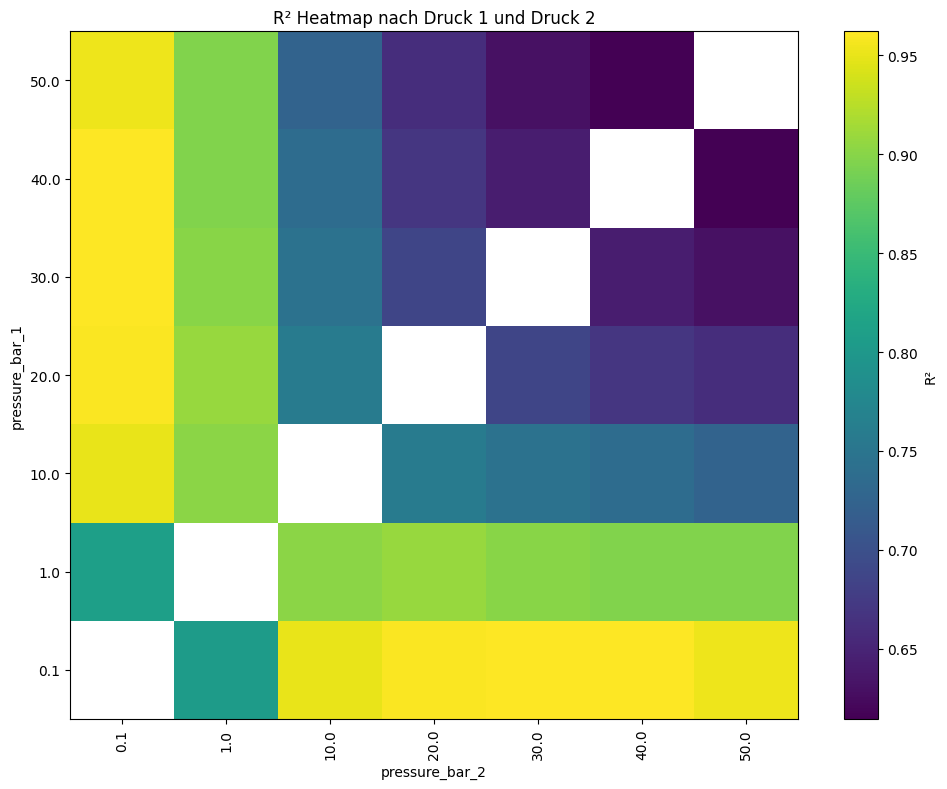

In [9]:

heatmap_data = doto.pivot_table(
    index="pressure_bar_1",
    columns="pressure_bar_2",
    values="r2",
    aggfunc="mean"        
)

# === Heatmap plotten ===
plt.figure(figsize=(10, 8))
plt.imshow(heatmap_data, aspect='auto', origin='lower')
plt.colorbar(label='R²')

plt.title("R² Heatmap nach Druck 1 und Druck 2")
plt.xlabel("pressure_bar_2")
plt.ylabel("pressure_bar_1")

# Achsenbeschriftungen mit den tatsächlichen Druckwerten
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=90)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)

plt.tight_layout()
plt.show()

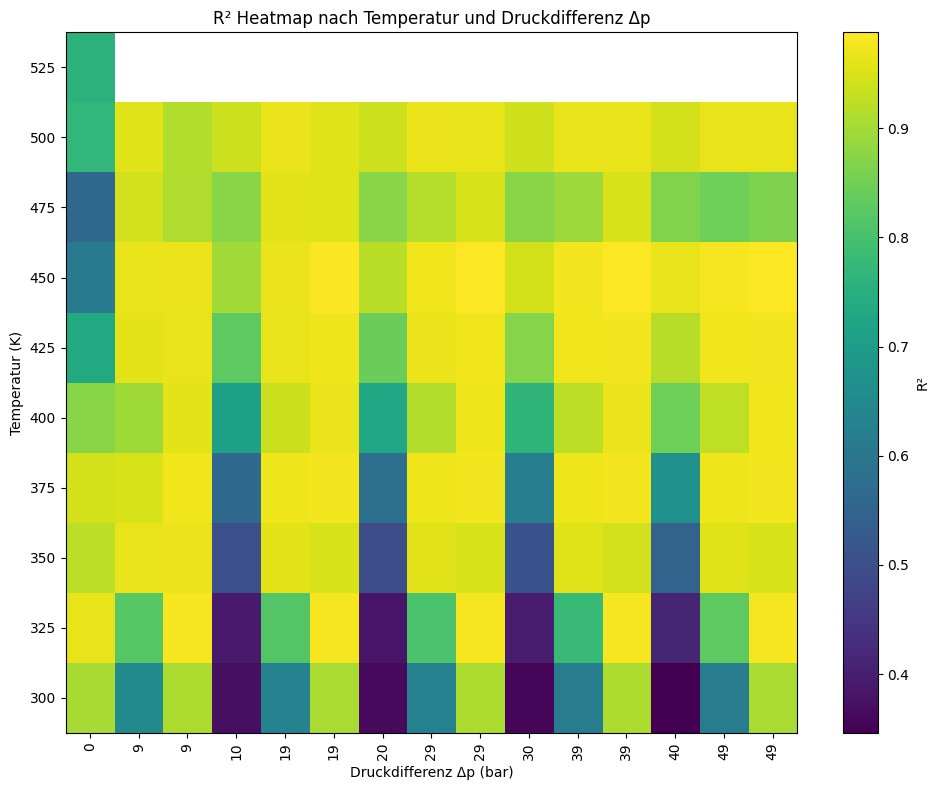

In [10]:
doto["delta_p"] = (doto["pressure_bar_2"] - doto["pressure_bar_1"]).abs()

# --- Pivot-Tabelle: Temperatur vs Δp ---
heatmap_data = doto.pivot_table(
    index="temperature_kelvin_1",   # Y-Achse
    columns="delta_p",            # X-Achse
    values="r2",                  # Farbe repräsentiert R²
    aggfunc="mean"                # Mittelwert, falls mehrere Kombinationen
)

# --- Sortierung (optional, für saubere Achsen) ---
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# --- Plot ---
plt.figure(figsize=(10, 8))
im = plt.imshow(heatmap_data, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(im, label="R²")

plt.title("R² Heatmap nach Temperatur und Druckdifferenz Δp")
plt.xlabel("Druckdifferenz Δp (bar)")
plt.ylabel("Temperatur (K)")

# Achsenbeschriftungen mit tatsächlichen Werten
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns.astype(int), rotation=90)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index.astype(int))

plt.tight_layout()
plt.show()

In [57]:
heatmap_data = doto.pivot_table(
    index="temperature_kelvin_1",     # Y-Achse: Temperatur
    columns="working_capacity",       # X-Achse: Working Capacity
    values="r2",                      # Farbe repräsentiert R²
    aggfunc="mean"                    # Mittelwert bei mehrfachen Werten
)

# --- Sortierung für saubere Darstellung ---
heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

# --- Plot ---
plt.figure(figsize=(10, 8))
im = plt.imshow(heatmap_data, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(im, label="R²")

plt.title("Heatmap: R² in Abhängigkeit von Temperatur und Working Capacity")
plt.xlabel("Working Capacity")
plt.ylabel("Temperatur (K)")

# Achsenbeschriftungen mit tatsächlichen Werten
plt.xticks(
    range(len(heatmap_data.columns)),
    [f"{x:.3f}" for x in heatmap_data.columns],
    rotation=90
)
plt.yticks(
    range(len(heatmap_data.index)),
    heatmap_data.index.astype(int)
)

plt.tight_layout()
plt.show()

KeyError: 'working_capacity'